# 1.简单改造，Conll2003数据集作测试

In [24]:
from tqdm.notebook import tqdm,trange
import os
class GetData:
    def read(self, data_path):
        data_parts = ['train', 'valid', 'test']
        extension = '.txt'
        dataset = {}
        bar = tqdm(data_parts)
        for data_part in bar:
            bar.set_description("正在读取数据集")
            file_path = os.path.join(data_path, data_part+extension)
            dataset[data_part] = self.read_file(str(file_path))
            if data_part == 'test':
                bar.set_description('数据读取完毕')
        return dataset

    def read_file(self, file_path):
        samples = []
        tokens = []   # 单词
        tags = []     # 实体标注
        with open(file_path,'r', encoding='utf-8') as fb:
            for line in fb:
                line = line.strip('\n')
                if line == '-DOCSTART- -X- -X- O':   # 去除数据头
                    pass
                elif line =='':                      # 一句话结束
                    if len(tokens) != 0:
                        samples.append((tokens, tags))
                        tokens = []
                        tags = []
                else:
                    items = line.split(' ')
                    tokens.append(items[0])
                    tags.append(items[-1])
        return samples

In [25]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)    # 人工设定随机种子以保证相同的初始化参数，实现模型的可复现性。

In [26]:
def argmax(vec):  # 给定输入二维序列，取每行（第一维度）的最大值，返回对应索引。
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):    # 利用to_ix这个word2id字典，将序列seq中的词转化为数字表示，包装为torch.long后返回
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):                # 函数目的相当于log∑exi 首先取序列中最大值，输入序列是一个二维序列(shape[1,tags_size])。下面的计算先将每个值减去最大值，再取log_sum_exp，最后加上最大值。
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [27]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim # 词嵌入维度，即输入维度
        self.hidden_dim = hidden_dim   # 隐层维度
        self.vocab_size = vocab_size   # 训练集词典大小
        self.tag_to_ix = tag_to_ix     # 标签索引表
        self.tagset_size = len(tag_to_ix) # 标注 类型数
        print(f'tagset_size={self.tagset_size}')
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)  # （词嵌入的个数，嵌入维度）
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,         # （输入节点数，隐层节点数，隐层层数，是否双向）
                            num_layers=1, bidirectional=True)       #  hidden_size除以2是为了使BiLSTM的输出维度依然是hidden_size,而不用乘以2

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)   # （输入x的维度，输出y的维度），将LSTM的输出线性映射到标签空间

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(                            # 转移矩阵，标注j转移到标注i的概率，后期要学习更新
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000     # 不会有标注转移到开始标注
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000      # 结束标注不会转移到其他标注

        self.hidden = self.init_hidden()

    def init_hidden(self):                                          # 初始化隐层（两层，3维）
        return (torch.randn(2, 1, self.hidden_dim // 2),            # (num_layer * num_direction, batch_size)
                torch.randn(2, 1, self.hidden_dim // 2))            # (隐层层数2 * 方向数1， 批大小1， 每层节点数)

    def _forward_alg(self, feats):                                  # 得到所有路径的分数/概率
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)    # P，(1, m)维，初始化为-10000
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas                                   # 前向状态，记录当前t之前的所有路径的分数
  
        # Iterate through the sentence
        for feat in feats:                                          # 动态规划思想，具体见onenote上的笔记
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha                                                # 返回的是所有路径的分数

    def _get_lstm_features(self, sentence):             # 通过BiLSTM层，输出得到发射分数
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)      # 对输入语句 词嵌入化
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)              # 词嵌入通过lstm网络输出,lstm传入参数之后会自动调用其forward方法
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)            # 将输出转为2维（原本是3维，但是batch_size=1，可以去掉这一维）
        lstm_feats = self.hidden2tag(lstm_out)                              # 将输出映射到标签空间，得到单词-分数表
        return lstm_feats

    def _score_sentence(self, feats, tags):             # 计算给定路径的分数
        # feats : LSTM的所有输出，发射分数矩阵
        # tags : golden路径的标注序列
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])   # 在标注序列最前加上开始标注
        for i, feat in enumerate(feats):                                                        # 计算给定序列的分数，Σ发散分数+Σ转移分数
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)                      # 初始化forward_var,并且 开始标注 的分数为0,确保一定是从START_TAG开始的,
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars                                                     # forward_var记录每个标签的前向状态得分，即w{i-1}被打作每个标签的对应得分值
        for feat in feats:                                                           # feats是LSTM的输出，每一个feat都是一个词w{i}，feat[tag]就是这个词tag标注的分数
            bptrs_t = []  # holds the backpointers for this step                     # 记录当前词w{i}对应每个标签的最优转移结点
            viterbivars_t = []  # holds the viterbi variables for this step          # 记录当前词各个标签w{i, j}对应的最高得分
                                                                                     # 动态规划：w{i，j}=max{forwar_var + transitions[j]}，词存于bptrs_t中，分数存于viterbivars_t中

            for next_tag in range(self.tagset_size):                                 # 对当前词w{i}的每个标签 运算
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)                                              # 记忆，方便回溯

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)                                            # 结束标记前的一个词的最高前向状态得分就是最优序列尾
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):                                        # 回溯
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):       # CRF的损失函数：-gold分数-logsumexp(所有序列)
        feats = self._get_lstm_features(sentence)                   # 通过BiLSTM层，获得每个 {词-标签}对 的发射分数
        forward_score = self._forward_alg(feats)                    # 根据发射分数计算所有路径的分数
        gold_score = self._score_sentence(feats, tags)              # 传入标注序列真实值，计算语句的真实分数gold_score
        return forward_score - gold_score                           # 返回误差值

    def forward(self, sentence):                                    # 重载前向传播函数，对象传入参数后就会自动调用该函数
        # Get the emission scores from the BiLSTM 
        lstm_feats = self._get_lstm_features(sentence)              # 通过LSTM层得到输出

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)           # 通过CFR层得到最优路径及其分数
        return score, tag_seq

In [33]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5       # 词嵌入维度
HIDDEN_DIM = 4          # 隐层层数

# Make up some training data
training_data = [(
    "the wall street journal reported today that apple corporation made money".split(),
    "B I I I O O O B I O O".split()
), (
    "georgia tech is a university in georgia".split(),
    "B I O O O O B".split()
)]
ds_rd = GetData()
data = ds_rd.read("./data")
training_data = data['train'][0:10]

word_to_ix = {}                             # 训练集词典 {词——索引}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {"B-PER": 0, "B-LOC": 1, "B-ORG": 2, "B-MISC": 3,
             "I-PER": 4, "I-LOC": 5, "I-ORG": 6, "I-MISC": 7,
             "O": 8, START_TAG: 9, STOP_TAG: 10}  # 标签词典 {标注——索引}


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)   # 模型BiLSTM-CRF
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)       # 优化器：使用SGD更新参数

# Check predictions before training
with torch.no_grad():                                                       # 在训练前测试一次预测结果，和训练后对比
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)       # 将第一个训练样本（词序列）转成索引序列
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long) # 将第一个训练样本的标签转成索引序列
    print(model(precheck_sent))                                             # 输出第一次预测的结果（model(·)自动调用forward函数）

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in trange(300,desc='模型训练进度'):  # again, normally you would NOT do 300 epochs, it is toy data     # 训练，迭代300次
    bar = tqdm(training_data, leave=False)
    for sentence, tags in bar:
        bar.set_description(f'epoch【{epoch}】')
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()                                                                   # 每次迭代前梯度清零（因为默认会叠加梯度）

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)                                # 输入：语句转为词索引
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)              # 真实值：标注序列转为索引

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)                               # 计算误差

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()                                                                     # 计算当前梯度，反向传播
        optimizer.step()                                                                    # 根据当前梯度更新网络参数

# Check predictions after training
# with torch.no_grad():                                                      # 在训练后预测一次预测，和训练前对比
#     precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
#     print(model(precheck_sent))
print('traning over!')
torch.save(model,'pre_model.pth')                                  # 保存模型
torch.save(model.state_dict(),'model_params.pth')                  # 保存模型参数

In [38]:
pre_model = torch.load('pre_model.pth')                            # 直接加载模型
with torch.no_grad():
    for i in range(10):
        test_data = data['train'][i]
        In = prepare_sequence(test_data[0],word_to_ix)
        Out= pre_model(In)
        print(f'模型预测输出: {Out}')
        targets = torch.tensor([tag_to_ix[tag] for tag in test_data[1]], dtype=torch.long)
        print(f'真值: {targets}')
        print(f'预测中词性标注错误的个数: {(torch.tensor(Out[1],dtype=torch.long)-targets).sum().item()}')
        print(Out[0])
        print(Out[1])
        print(type(Out[1][0]))
        print()
        # We got it!

模型预测输出: (tensor(72.7139), [1, 8, 3, 8, 8, 8, 3, 8, 8])
真值: tensor([2, 8, 3, 8, 8, 8, 3, 8, 8])
预测中词性标注错误的个数: -1
tensor(72.7139)
[1, 8, 3, 8, 8, 8, 3, 8, 8]
<class 'int'>

模型预测输出: (tensor(9.0805), [0, 4])
真值: tensor([0, 4])
预测中词性标注错误的个数: 0
tensor(9.0805)
[0, 4]
<class 'int'>

模型预测输出: (tensor(14.2910), [1, 8])
真值: tensor([1, 8])
预测中词性标注错误的个数: 0
tensor(14.2910)
[1, 8]
<class 'int'>

模型预测输出: (tensor(267.7945), [8, 2, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
真值: tensor([8, 2, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8])
预测中词性标注错误的个数: 0
tensor(267.7945)
[8, 2, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
<class 'int'>

模型预测输出: (tensor(266.3945), [1, 8, 8, 8, 8, 2, 6, 8, 8, 8, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8])
真值: tensor([1, 8, 8, 8, 8, 2, 6, 8, 8, 8, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1,
        8, 8, 8, 8, 8, 8, 8])
预测中词性标注错误的个数

In [36]:
model2 = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)           # 读取参数加载模型
model2.load_state_dict(torch.load('model_params.pth'))
with torch.no_grad():
    for i in range(10):
        test_data = data['train'][i]
        In = prepare_sequence(test_data[0],word_to_ix)
        Out = model2(In)
        print(f'模型预测输出: {Out}')
        targets = torch.tensor([tag_to_ix[tag] for tag in test_data[1]], dtype=torch.long)
        print(f'真值: {targets}')
        print(f'预测中词性标注错误的个数: {(torch.tensor(Out[1],dtype=torch.long)-targets).sum().item()}')
        print()
        # We got it!

tagset_size=11
模型预测输出: (tensor(70.8756), [1, 8, 3, 8, 8, 8, 3, 8, 8])
真值: tensor([2, 8, 3, 8, 8, 8, 3, 8, 8])
预测中词性标注错误的个数: -1

模型预测输出: (tensor(10.9569), [0, 4])
真值: tensor([0, 4])
预测中词性标注错误的个数: 0

模型预测输出: (tensor(14.2688), [1, 8])
真值: tensor([1, 8])
预测中词性标注错误的个数: 0

模型预测输出: (tensor(267.0723), [8, 2, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
真值: tensor([8, 2, 6, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8])
预测中词性标注错误的个数: 0

模型预测输出: (tensor(263.2603), [1, 8, 8, 8, 8, 2, 6, 8, 8, 8, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8])
真值: tensor([1, 8, 8, 8, 8, 2, 6, 8, 8, 8, 0, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1,
        8, 8, 8, 8, 8, 8, 8])
预测中词性标注错误的个数: 0

模型预测输出: (tensor(292.0675), [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 0, 4, 4, 4, 8, 8, 8, 8, 8])
真值: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8,
        0, 4, 4, 4, 

In [24]:
# from tqdm.notebook import trange, tqdm
# from time import sleep
# out_bar = trange(5, desc='训练中',colour='red')
# for i in out_bar:
#     bar = tqdm(range(2), desc='2nd loop', leave=False)
#     for j in bar:
#         bar.set_description(f'epoch【{i}】')
#         sleep(0.5)
#     if i == 4:
#         out_bar.set_description('训练完毕')
        
# #     out_bar.set_description('总进度: ')

训练中:   0%|          | 0/5 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/2 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/2 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/2 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/2 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/2 [00:00<?, ?it/s]

# 2.输入（Json文件）处理

In [4]:
pip install pandas


     ---------------------------------------- 10.6/10.6 MB 9.4 MB/s eta 0:00:00


In [40]:
import pandas as pd
from tqdm import tqdm

In [41]:
file = './data/data.json'
df = pd.read_json(file)
a, b = df.loc[4]
print(type(a))
print(b)
print(len(df)//5*4)
df

<class 'str'>
[['NAME', [3, 14]], ['TICKER', [35, 39]], ['NOTIONAL', [21, 34]]]
2400


,text,label
0,Dear 568.763million AXNVF,"[[TICKER, [20, 25]], [NOTIONAL, [5, 19]]]"
1,Buy 703.363thousand HEOFF,"[[TICKER, [20, 25]], [NOTIONAL, [4, 19]]]"
2,May I 927.795hundred RLXXF Put,"[[TICKER, [21, 26]], [NOTIONAL, [6, 20]]]"
3,77.574hundred BRGGF,"[[TICKER, [14, 19]], [NOTIONAL, [0, 13]]]"
4,Hi Mark Romero Can I 66.585million ABST Thank ...,"[[NAME, [3, 14]], [TICKER, [35, 39]], [NOTIONA..."
...,...,...
2995,860.036 PCLOF Buy,"[[TICKER, [8, 13]], [NOTIONAL, [0, 7]]]"
2996,Jennifer Long Can I 956.436thousand CAE call ...,"[[NAME, [1, 14]], [TICKER, [37, 40]], [NOTIONA..."
2997,May I 282.922billion FTRP,"[[TICKER, [21, 25]], [NOTIONAL, [6, 20]]]"
2998,49.527trillion NSCIF sell,"[[TICKER, [15, 20]], [NOTIONAL, [0, 14]]]"


In [43]:
# word_to_ix = {}                             # 训练集词典 {词——索引}
# for sentence, tags in training_data:
#     for word in sentence:
#         if word not in word_to_ix:
#             word_to_ix[word] = len(word_to_ix)
# START_TAG = "<START>"
# STOP_TAG = "<STOP>"
# tag_to_ix = {"B-NAM": 0, "B-TIC": 1, "B-NOT": 2, 
#              "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
#              "O": 6, START_TAG: 7, STOP_TAG: 8}  # 标签词典 {标注——索引}

# word_to_ix = {}                             # 训练集词典 {词——索引}
# for sentence, tags in training_data:
#     for word in sentence:
#         if word not in word_to_ix:
#             word_to_ix[word] = len(word_to_ix)
# START_TAG = "<START>"
# STOP_TAG = "<STOP>"
# tag_to_ix = {"B-NAM": 0, "B-TIC": 1, "B-NOT": 2, 
#              "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
#              "O": 6, START_TAG: 7, STOP_TAG: 8}  # 标签词典 {标注——索引}

def get_tags(label, tokens):
    length = len(tokens)
    tags = ['O'] * length
    index = []*length
    last = 0
    for i in range(length):
        index.append(last+len(tokens[i]))
        last = index[-1]+1
#     print(index)
    label.sort(key = lambda x: x[1][0])
    help_map = {0:'B-', 1:'I-'}
#     print(label)
    label2 = [(l, x[0:3]) for x, y in label for l in y]
#     print(label2)
    i, j = 0, 0
    while i < length and j < len(label):    # 双指针
#         print(f'{label[j][1][0]}  {index[i]} {label[j][1][1]}')
        if label[j][1][0] < index[i] <= label[j][1][1]:
            tags[i] = label[j][0][0:3]
        if index[i] > label[j][1][1]:
            j+=1
            i-=1
        i += 1
    for i in range(length-1, -1, -1):
        if tags[i] != 'O':
            if i == 0 or tags[i-1] != tags[i]:
                tags[i] = f'B-{tags[i]}'
            else:
                tags[i] = f'I-{tags[i]}'
    return tags
# test_label = [['TICKER', [21, 26]], ['NOTIONAL', [6, 20]]]
# sentence = 'May I 927.795hundred RLXXF Put'

# # test_label = [['Name', [3, 16]],['TICKER', [37, 41]], ['NOTIONAL', [23, 36]]]
# # sentence = 'Hi Mark Romero K Can I 66.585million ABST Thank you.'

# test_label = [['Name', [3, 16]],['TICKER', [45, 50]], ['NOTIONAL', [29, 44]]]
# sentence = 'Hi Daniel Joseph , May I Buy 678.559thousand PSHIF '

# print(get_tags(test_label, sentence.split()))

[2, 9, 16, 18, 22, 24, 28, 44, 50]
[['Name', [3, 16]], ['NOTIONAL', [29, 44]], ['TICKER', [45, 50]]]
[(3, 'Nam'), (16, 'Nam'), (29, 'NOT'), (44, 'NOT'), (45, 'TIC'), (50, 'TIC')]
3  2 16
3  9 16
3  16 16
3  18 16
29  18 44
29  22 44
29  24 44
29  28 44
29  44 44
29  50 44
45  50 50
['O', 'B-Nam', 'I-Nam', 'O', 'O', 'O', 'O', 'B-NOT', 'B-TIC']


In [43]:
data_size = len(df)
data_set = {'training': [], 'test': []}
tokens = []
tags = []
word_to_ix = {}
for i in tqdm(range(0, data_size//5*4), desc='读取训练数据', position=0):
    text, label = df.loc[i]
    tokens = text.split()
    tags = get_tags(label, len(text))
    for word in tokens:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    data_set['training'].append((tokens, tags))
for i in tqdm(range(data_size//5*4, data_size), desc='读取测试数据', position=0):
    text, label = df.loc[i]
    tokens = text.split()
    tags = get_tags(label, len(text))
    for word in tokens:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    data_set['test'].append((tokens, tags))
print(len(data_set['training']))
print(len(data_set['test']))
print(len(word_to_ix))

读取测试数据: 100%|███████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 17694.25it/s]

2400
600
4270


# 3.损失函数测试

torch.Size([3])
torch.Size([3])
SmoothL1Loss tensor(0.1067)
SmoothL1Loss2 tensor(0.0817)
SmoothL1Loss2 tensor(0.1083)
tensor([[ 0.6123,  1.4574, -0.8892,  ...,  0.0050,  0.4898,  0.2029],
        [-0.3059,  0.4671,  0.7391,  ..., -0.3981,  1.7851, -1.0114],
        [-0.2853,  0.3888,  1.3631,  ..., -0.6380,  1.0693, -0.2788],
        ...,
        [-0.8388, -2.1040, -0.5288,  ..., -1.7141,  1.0215,  0.1173],
        [-0.0771,  0.6776,  2.5670,  ..., -0.4080,  1.2608, -0.1725],
        [ 0.7068, -1.2096, -0.9916,  ..., -1.1053,  0.1050, -0.1743]])
tensor([[-4.5344e-01, -1.1273e+00,  9.2994e-01,  ...,  3.9153e-01,
         -1.0993e+00, -8.1346e-01],
        [ 8.1977e-01, -6.0418e-01,  1.2448e+00,  ..., -7.7001e-04,
          5.8065e-01, -3.2354e-01],
        [-6.2533e-01,  7.8292e-02,  3.0498e-01,  ...,  3.3939e-01,
         -3.9383e-01,  2.5305e-01],
        ...,
        [-6.8670e-01,  9.1317e-01, -1.1309e+00,  ...,  1.4562e+00,
          1.5861e-02,  6.3571e-01],
        [ 9.9312e-01, -

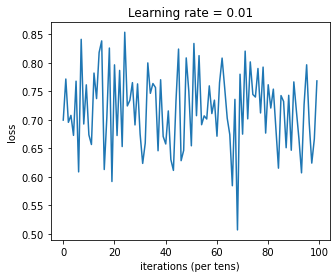

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
 
bce_loss = torch.nn.BCELoss()
 
crit = torch.nn.SmoothL1Loss()
pre = torch.Tensor([0.5, 1.6, 1])
target =  torch.Tensor([0.5, 0.8, 1])
x = torch.randn(100, 100)
y = torch.randn(100, 100)
target2 =  torch.Tensor([0.5, 0.9, 1])
target3 =  torch.Tensor([0.5, 0.8, 1.1])
print(pre.size())
print(target.size())
print('SmoothL1Loss',crit(pre, target))
print('SmoothL1Loss2',torch.nn.functional.smooth_l1_loss(pre,target2)) #target放在右边，pre只能在0-1之间
print('SmoothL1Loss2',torch.nn.functional.smooth_l1_loss(pre,target3)) #target放在右边，pre只能在0-1之间
# print('bce2',bce_loss(pre, target))
print(x)
print(y)
loss = [crit(a,b) for a,b in zip(x,y)]
print(loss)

plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图像显示大小
plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
plt.plot(np.squeeze(loss))
plt.ylabel('loss')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate = 0.01")
plt.show()

In [19]:
a = "a b c tentst"
a.split()

['a', 'b', 'c', 'tentst']

# 4.测试获取实体

In [14]:
from collections import defaultdict
def get_entity(ix_seq, sentence):
    ix_to_tag = {  # 标签词典 {标注——索引}
        0: "NAME",  1: "TICKER",  2: "NOTIONAL",
        # 3: "I-NAM",  4: "I-TIC",  5: "I-NOT",
        # 6: "0", 7: "<START>", 8: "<START>"
    }
    # tag_seq = [ix_to_tag[ix] for ix in ix_seq]
    entities = defaultdict(str)
    tokens = sentence.split()
    i = 0
    while i < len(ix_seq):
        ix = ix_seq[i]
        if ix in ix_to_tag:
            j = i+1
            while j < len(ix_seq) and ix_seq[j] == ix+3:
                j += 1
            entities[ix_to_tag[ix]] = ' '.join(tokens[i: j])
            i = j-1
        i += 1
    return entities

In [17]:
# sentence = "Hi Douglas Bell K , Can I Call 8.294t UUUU"
# tag_to_ix = {"B-NAM": 0, "B-TIC": 1, "B-NOT": 2, 
#              "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
#              "O": 6}  # 标签词典 {标注——索引}
# tag_seq = ['O', 'O', 'O', 'O', 'O', 'O', 'B-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'O', 'B-TIC', 'I-TIC', 'I-TIC', 'I-TIC', 'I-TIC']
# # ix_seq = [tag_to_ix[tag] for tag in tag_seq]
# ix_seq = [6, 0, 3, 3, 6, 6, 6, 6, 2, 1]
# get_entity(ix_seq, sentence)
import torch
from bilstm_crf import prepare_sequence
from read_data import read
def nlp(sentence):
    pre_model = torch.load('pre_model.pth')  # 直接加载模型
    data_set, word_to_ix = read('./data/data.json')
    with torch.no_grad():
        tokens = sentence.split()
        model_in = prepare_sequence(tokens, word_to_ix)
        model_out = pre_model(model_in)
        nlp_result = get_entity(model_out[1], sentence)
    # nlp_result = {
    #     "NAME": "",
    #     "TICKER": "",
    #     "NOTIONAL": ""
    # }
    return nlp_result

nlp('Hello Amy Nelson , 506.807b EXROF sell')

读取测试数据: 100%|███████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 15409.47it/s]

2400
600


defaultdict(str,
            {'NAME': 'Amy Nelson', 'NOTIONAL': '506.807b', 'TICKER': 'EXROF'})

# 5.模型训练测试

# 6.尝试batch（失败）

In [5]:
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

BATCH_SIZE = 3
x = torch.linspace(1,12,12)
y = torch.linspace(12,1,12)
print(x)
print(y)

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
tensor([12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])


In [ ]:
torch_dataset = TensorDataset(x,y)
loader = DataLoader(dataset = torch_dataset, batch_size = BATCH_SIZE, 
                         shuffle = True, num_workers = 2)

for epoch in range(5):
    for step, (batch_x, batch_y) in enumerate(loader):
        print(f'Epoch:{epoch} | num:{i} || batch_x:{batch_x} || batch_y:{batch_y}')

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim


torch.manual_seed(1)    # 人工设定随机种子以保证相同的初始化参数，实现模型的可复现性。
START_TAG = "<START>"
STOP_TAG = "<STOP>"


def argmax(vec):  # 给定输入二维序列，取每行（第一维度）的最大值，返回对应索引。
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix, tags, tag_to_ix, max_length):    # 利用to_ix这个word2id字典，将序列seq中的词转化为数字表示，包装为torch.long后返回
    idxs = [to_ix[w] for w in seq]
    tidxs = [tag_to_ix[tag] for tag in tags]
    length = len(idx)
    for i in range(max_length-length:
        idxs.append(0)
        tidxs.append(6)
#     return torch.tensor(idxs, dtype=torch.long)
    return idxs, tidxs


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):                # 函数目的相当于log∑exi 首先取序列中最大值，输入序列是一个二维序列(shape[1,tags_size])。下面的计算先将每个值减去最大值，再取log_sum_exp，最后加上最大值。
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


# def compute_loss(self, pre, target):
#     loss_func = torch.nn.SmoothL1Loss()
#     loss = [loss_func(x, y) for x, y in zip(pre, target)]
#     plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图像显示大小
#     plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
#     plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
#     plt.plot(np.squeeze(loss))
#     plt.ylabel('loss')
#     plt.xlabel('iterations (per tens)')
#     plt.title("Learning rate = 0.01")
#     plt.show()


class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim  # 词嵌入维度，即输入维度
        self.hidden_dim = hidden_dim  # 隐层维度
        self.vocab_size = vocab_size  # 训练集词典大小
        self.tag_to_ix = tag_to_ix  # 标签索引表
        self.tagset_size = len(tag_to_ix)  # 标注 类型数
        print(f'tagset_size={self.tagset_size}')
        self.word_embeds = nn.Embedding(vocab_size,
                                        embedding_dim)  # （词嵌入的个数，嵌入维度）
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2,
                            # （输入节点数，隐层节点数，隐层层数，是否双向）
                            num_layers=1,
                            bidirectional=True)  # hidden_size除以2是为了使BiLSTM
        # 的输出维度依然是hidden_size,而不用乘以2

        # Maps the output of the LSTM into tag space.
        # （输入x的维度，输出y的维度），将LSTM的输出线性映射到标签空间
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(  # 转移矩阵，标注j转移到标注i的概率，后期要学习更新
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000  # 不会有标注转移到开始标注
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000  # 结束标注不会转移到其他标注

        self.hidden = self.init_hidden()

    def init_hidden(self):  # 初始化隐层（两层，3维）
        # (num_layer * num_direction, batch_size)
        # (隐层层数2 * 方向数1， 批大小1， 每层节点数)
        return (torch.randn(2, 1, self.hidden_dim//2),
                torch.randn(2, 1, self.hidden_dim//2))

    def _forward_alg(self, feats):  # 得到所有路径的分数/概率
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size),
                                 -10000.)  # P，(1, m)维，初始化为-10000
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas  # 前向状态，记录当前t之前的所有路径的分数

        # Iterate through the sentence
        for feat in feats:  # 动态规划思想，具体见onenote上的笔记
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1,
                                                               self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var+trans_score+emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var+self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha  # 返回的是所有路径的分数

    def _get_lstm_features(self, sentence):  # 通过BiLSTM层，输出得到发射分数
        self.hidden = self.init_hidden()
        # 对输入语句 词嵌入化
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        # 词嵌入通过lstm网络输出,lstm传入参数之后会自动调用其forward方法
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # 将输出转为2维（原本是3维，但是batch_size=1，可以去掉这一维）
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)  # 将输出映射到标签空间，得到单词-分数表
        return lstm_feats

    def _score_sentence(self, feats, tags):  # 计算给定路径的分数
        # feats : LSTM的所有输出，发射分数矩阵
        # tags : golden路径的标注序列
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat(
            [torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long),
                tags])  # 在标注序列最前加上开始标注
        for i, feat in enumerate(feats):  # 计算给定序列的分数，Σ发散分数+Σ转移分数
            score = score+self.transitions[tags[i+1], tags[i]]+feat[tags[i+1]]
        score = score+self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        # 初始化forward_var,并且 开始标注 的分数为0,确保一定是从START_TAG开始的,
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        # forward_var记录每个标签的前向状态得分，即w{i-1}被打作每个标签的对应得分值
        forward_var = init_vvars

        # feats是LSTM的输出，每一个feat都是一个词w{i}，feat[tag]就是这个词tag标注的分数
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step记录当前词w{i}对应每个标签的最优转移结点
            viterbivars_t = []  # holds the viterbi variables for this step 记录当前词各个标签w{i, j}对应的最高得分
            # 动态规划：w{i，j}=max{forwar_var + transitions[j]}，词存于bptrs_t中，分数存于viterbivars_t中

            for next_tag in range(self.tagset_size):  # 对当前词w{i}的每个标签 运算
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var+self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t)+feat).view(1, -1)
            backpointers.append(bptrs_t)  # 记忆，方便回溯

        # Transition to STOP_TAG
        terminal_var = forward_var+self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)  # 结束标记前的一个词的最高前向状态得分就是最优序列尾
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):  # 回溯
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):  # CRF的损失函数：-gold分数-logsumexp(所有序列)
        feats = self._get_lstm_features(
            sentence)  # 通过BiLSTM层，获得每个 {词-标签}对 的发射分数
        forward_score = self._forward_alg(feats)  # 根据发射分数计算所有路径的分数
        gold_score = self._score_sentence(feats, tags)  # 传入标注序列真实值，计算语句的真实分数gold_score
        return forward_score-gold_score  # 返回误差值

    def forward(self, sentence):  # 重载前向传播函数，对象传入参数后就会自动调用该函数
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)  # 通过LSTM层得到输出

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)  # 通过CFR层得到最优路径及其分数
        return score, tag_seq

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# from bilstm_crf import *
from read_data import read


START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5  # 词嵌入维度
HIDDEN_DIM = 4  # 隐层层数
tag_to_ix = {  # 标签词典 {标注——索引}
    "B-NAM": 0, "B-TIC": 1, "B-NOT": 2,
    "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
    "O": 6, START_TAG: 7, STOP_TAG: 8
}
data_set, word_to_ix = read('./data/data.json')  # 数据集，词典 {词——索引}



In [ ]:

def compute_loss(pre, target):
    loss_func = torch.nn.SmoothL1Loss()
    loss = [loss_func(x, y) for x, y in zip(pre, target)]
    plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图像显示大小
    plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
    plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
    plt.plot(np.squeeze(loss))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate = 0.01")
    plt.show()


def add_batch(data_input, data_label, batch_size):
    print(data_input[0])
    print(data_label[0])
    print(torch.Tensor(data_input).size(0))
    print(len(data_label))
#     data_input = torch.Tensor(data_input)
#     data_label = torch.Tensor(data_label)
#     print(len(data_input))
#     print(len(data_label))
    data = TensorDataset(torch.tensor(data_input, dtype=torch.long), torch.tensor(data_label, dtype=torch.long))
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False) #shuffle是是否打乱数据集，可自行设置

    return data_loader


def train():
    # data_set, word_to_ix = read('./data/data.json')  # 数据集，词典 {词——索引}
    training_data = data_set['training']

    model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    data_in, data_label = [], []
    max_length = len(max(training_data, key = lambda x: len(x[0]))[0])
    for tokens, tags in training_data:
        token_ix, tag_ix = prepare_sequence(tokens, word_to_ix, tags, tag_to_ix, max_length)
        data_in.append(token_ix)
#         data_label.append(torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long))
        data_label.append(tag_ix)
    training_batch = add_batch(data_in, data_label, 100)
    # Make sure prepare_sequence from earlier in the LSTM section is loaded
    for epoch in trange(300, desc='模型训练进度'):
        bar = tqdm(enumerate(training_batch), leave=False)
        for step, (sentence, tags) in bar:
            bar.set_description(f'epoch【{epoch}】')
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
#             print('=======')
#             print(sentence.size(0))
#             print(tags)
            # Step 2. Get our inputs ready for the network, that is,
            # turn them into Tensors of word indices.
#             sentence_in = prepare_sequence(sentence, word_to_ix)
#             targets = torch.tensor([tag_to_ix[t] for t in tags],
#                                    dtype=torch.long)

            # Step 3. Run our forward pass.
            loss = model.neg_log_likelihood(sentence, tags)

            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0: # https://blog.csdn.net/u013250861/article/details/124657801
                state = {
                    'epoch' : epoch + 1,                  # 保存当前的迭代次数
                    'state_dict' : model.state_dict(),    # 保存模型参数
                    'optimizer' : optimizer.state_dict(), # 保存优化器参数
                }
                torch.save(state, f'./checkpoint2/checkpoint{epoch}.pth.tar')
    print('training over!')
    torch.save(model, 'pre_model.pth')
    torch.save(model.state_dict(), 'model_params.pth')
    
train()

# 7.词典转文件

In [6]:
entity_set = {'NAME':set(), 'TICKER':set(), 'NOTIONAL':set()}
O_set = set()
tag_to_ix = {  # 标签词典 {标注——索引}
    "B-NAM": 0, "B-TIC": 1, "B-NOT": 2,
    "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
    "O": 6, START_TAG: 7, STOP_TAG: 8
}

In [7]:
def get_entity(ix_seq, sentence):
    ix_to_tag = {0: "NAME", 1: "TICKER", 2: "NOTIONAL", }
    # tag_seq = [ix_to_tag[ix] for ix in ix_seq]
    entities = defaultdict(str)
    tokens = sentence.split()
    i = 0
    while i < len(ix_seq):
        ix = ix_seq[i]
        if ix in ix_to_tag:
            j = i+1
            while j < len(ix_seq) and ix_seq[j] == ix+3:
                j += 1
            entities[ix_to_tag[ix]] = ' '.join(tokens[i: j])
            entity_set[ix_to_tag[ix]].add(' '.join(tokens[i: j]))
            i = j-1
        else:
            O_set.add(tokens[i])
        i += 1
    return entities

In [ ]:
import pandas as pd
from tqdm import tqdm


# def get_tags(label, length):
#     tags = ['O'] * length
#     for entity_type, [start, end] in label:
#         entity_type = entity_type[0:3]
#         tags[start] = 'B-' + entity_type
#         for i in range(start+1, end):
#             tags[i] = 'I-' + entity_type
#     return tags


def get_tags(label, tokens):
    length = len(tokens)
    tags = ['O'] * length
    index = []*length
    last = 0
    for i in range(length):
        index.append(last+len(tokens[i]))
        last = index[-1]+1
#     print(index)
    label.sort(key = lambda x: x[1][0])
    help_map = {0:'B-', 1:'I-'}
#     print(label)
    label2 = [(l, x[0:3]) for x, y in label for l in y]
#     print(label2)
    i, j = 0, 0
    while i < length and j < len(label):    # 双指针
        if label[j][1][0] < index[i] <= label[j][1][1]:
            tags[i] = label[j][0][0:3]
        if index[i] > label[j][1][1]:
            j += 1
            i -= 1
        i += 1
    for i in range(length-1, -1, -1):
        if tags[i] != 'O':
            if i == 0 or tags[i-1] != tags[i]:
                tags[i] = f'B-{tags[i]}'
            else:
                tags[i] = f'I-{tags[i]}'
    return tags


def read(file):
    df = pd.read_json(file)
    data_size = len(df)
    data_set = []
    for i in tqdm(range(0, data_size), desc='读取数据', position=0):
        text, label = df.loc[i]
        with open('./data/sentence.txt', 'w+') as f:
            f.writelines(f'{text}\n')  #文件的写操作
        tokens = text.split()
        tags = get_tags(label, tokens)
        result = get_entity([tag_to_ix[tag] for tag in tags], text)
        data_set.append((tokens, tags))
        
    df2 = pd.DataFrame(data_set)
    return data_set, df2

_, dd = read('./data/data.json')

# with open('./data/NAME.txt', 'w') as f:
#     for s in entity_set['NAME']:
#         f.writelines(f'{s}\n')  #文件的写操作
# with open('./data/TICKER.txt', 'w') as f:
#     for s in entity_set['TICKER']:
#         f.writelines(f'{s}\n')  #文件的写操作
# with open('./data/NOTIONAL.txt', 'w') as f:
#     for s in entity_set['NOTIONAL']:
#         f.writelines(f'{s}\n')  #文件的写操作
# with open('./data/O.txt', 'w') as f:
#     for s in O_set:
#         f.writelines(f'{s}\n')  #文件的写操作
dd